In [31]:
# !python -m pip install numpy
# !python -m pip install matplotlib
# !python -m pip install pandas
# !conda install -c conda-forge python-graphviz
!python -m pip install torch

  Using cached torch-2.6.0-cp310-cp310-manylinux1_x86_64.whl (766.7 MB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl (363.4 MB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl (883 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl (24.6 MB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl (664.8 MB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl (211.5 MB)
  Using cached jinja2-3.1.6-py3-none-any.whl (134 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl (207.5 MB)
ERROR: Could not install packages due to an OSError: [Errno 28] No space left on device

You should consider upgrading via the '/home/rit/neural_net_karpathy/.venv/bin/python -m pip install --upgrade pip' command.


In [20]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [71]:
class Value:
    """ stores a single scalar value and its gradient """

    # op to define operation
    # children to store the children of the value
    # data to store the value
    def __init__(self, data, _children=(), _op='',label=''):
        self.data = data
        self.grad=0.0 # gradient of the value
        self._backward= lambda: None # backward propagation
        self._prev = set(_children)
        self._op = _op
        self.label= label
    # __ method used to define operator like add, subtract, multiply, divide
    
    def __add__(self, other):
        # for now we can just add 2 data objects , now we will check how to add data with an integer value directly
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data,(self, other), '+') # self, other are children of the value
        def _backward():
            self.grad += 1.0 * out.grad # local derivative of self is 1.0 so 1.0 * out.grad <----- chain rule for + operator
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        # same as add but for multiplication
        # but here a*1 works but 1*a does not work so we create rmul method to handle this
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data,(self, other),'*')
        def _backward():
            # a problem might appear if expression is b= a+a and db/da shd be 2 but it gives 1 if we dont put + = after self.grad and after other.grad
            # so we need to add the gradient to the existing gradient for all expressions to avoid problem incase of repetation of variables or multivariables
            self.grad += other.data * out.grad # local derivative of self is other.data so other.data * out.grad <----- chain rule for * operator
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    # negetion to implement subtration
    def __neg__(self): # -self
        return self * -1

    # a+ neg(b)
    def __sub__(self, other): # self - other, 
        return self + (-other)
        
    def __truediv__(self, other):
        if isinstance(other, Value):
            out = Value(self.data / other.data, (self, other), '/')
        else:
            out = Value(self.data / other, (self,), '/')
        def _backward():
            self.grad += other.data / out.grad
            other.grad += self.data / out.grad
        out._backward = _backward
        return out

    # to do a* b^-1 we need power function
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            # dx^n/dx= nx^(n-1) by chain rule -- other * (self.data ** (other - 1)) * out.grad 
            self.grad += other * (self.data ** (other - 1)) * out.grad 
        out._backward = _backward

        return out
    
    # a/b = a * b^-1
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    # to define exponentiation
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            # de^x/dx = e^x so e^x * out.grad <----- chain rule for exp operator
            self.grad += out.data * out.grad # derivative of exp is exp so exp * out.grad <----- chain rule for exp operator
        out._backward = _backward
        
        return out

    
    def __tanh__(self):
        x = self.data
        # tan h formula
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad # derivative of tanh is 1 - tanh^2 so (1 - t**2) * out.grad <----- chain rule for tanh operator
        out._backward = _backward
            
        return out
    
    def backward(self):
        # topological sort of the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
            # self that is the input o node will add itself after all the children have been processed
            # so that the gradient is calculated correctly
        build_topo(self)
        
        self.grad = 1.0
        # as o shd start from 1 and goes topologically in reverse order
        for node in reversed(topo):
            node._backward()

    # to return the value
    def __repr__(self):
        return f"Value(data={self.data})"


In [3]:
a= Value(2.0, label='a')
print(a+1)
print(a*2)
print(2*a)
print(a.exp())
b= Value(4.0, label='b')
print(a/b)
print(a-b)

Value(data=3.0)
Value(data=4.0)
Value(data=4.0)
Value(data=7.38905609893065)
Value(data=0.5)
Value(data=-2.0)


In [4]:
# lets draw the neural net draw previously again

In [5]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


In [6]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# increasing bias
# b = Value(8.0, label='b') #increases the output to 1 max value of tanh
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# activation function
o = n.__tanh__(); o.label = 'o'

# back propogation
o.backward()

Fontconfig warning: ignoring C.UTF-8: not a valid language tag


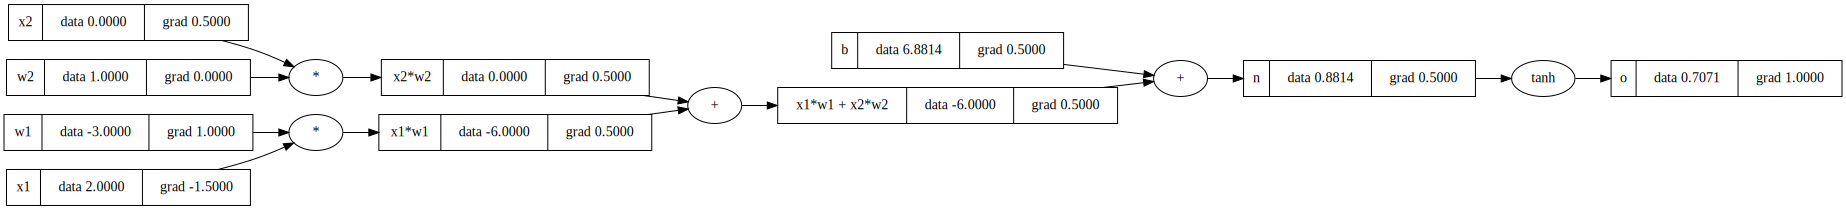

In [7]:
draw_dot(o)

In [8]:
# breaking up tanh into a formula
# as we hav broken pup tanh using other operations the graph will be longer
# result shd be same for o
# same backward pass and same gradients shd be seen

Fontconfig warning: ignoring C.UTF-8: not a valid language tag


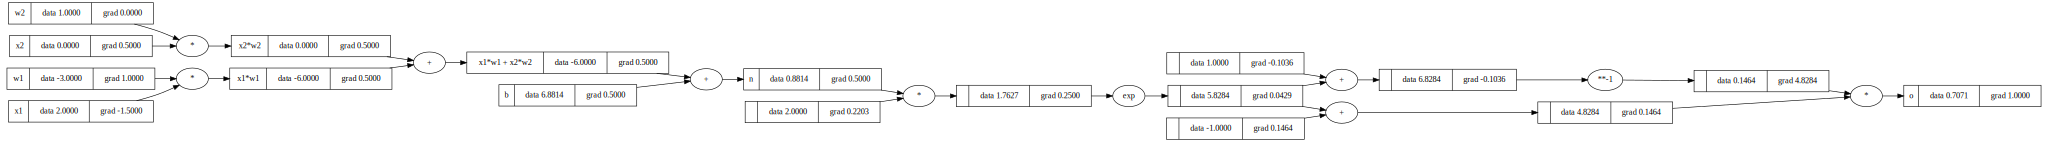

In [9]:

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# braeking tanh to the formula
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [ ]:
# using pytorch to build micrograd kind of neural net , micrograd is single value element 
# tensors collection of arrays and dimensions
# only difference b/w micrograd and torch is that torch can do the operations in tensors and micrograd can do in single element value
import torch

In [16]:

# defining the values as torch tensors of single element
# as these are leaf nodes we have to mention that they require gradients
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
#torch has tanh function predefined
o = torch.tanh(n)

print(o.data.item())
# tensors has their backward function prebuilt
o.backward()

print('---')
# torch has grad atribute and .item will strip of the tensor gust give the gradient element
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [15]:
o.item()

0.7071066904050358

In [17]:
# building a Neural Network using torch

## MLP( Multilayer Perceptron)
each layer of neuron connected to every other neurons in its adjacent layer
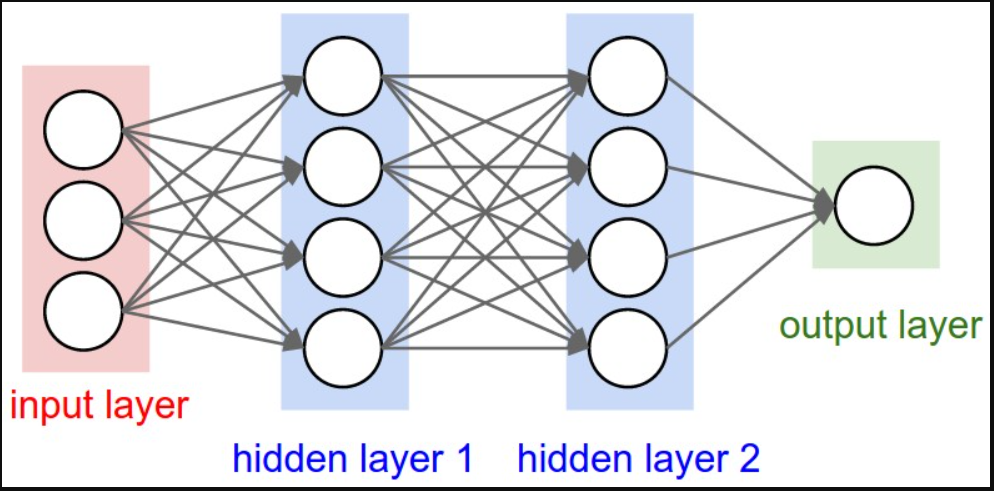

In [45]:
class Neuron:
  
  # initializing weights and bias by uniform random numbers b/w -1,1
  # nin is te range b/w which the random nos shd be
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

# to forward a single neuron
  def __call__(self, x):
    # w * x + b <---- calculation then passing through activation function which is tanh
    # implement this calcualtion to all weights and x thus we use zip function
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    # passing through activation from micrograd
    out = act.__tanh__()
    return out
  
  # all parameters of neural networks
  def parameters(self):
    return self.w + [self.b]

# making a layer
class Layer:
  # number of neurons we want in a layer is nout
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  # independently evaluate on each neuron
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    # just to get a single element not values of data if their is only single element in the tensor
    return outs[0] if len(outs) == 1 else outs
  
  # pareametes of each neuron in layer is added up to the original prameter function
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]
  
# making an MLP
class MLP:
  # list of nins<--sizes of all the layers in mplp
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    # iterate over consecutive pairs of sizes and create layer objects for them 
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  # calling each layer sequentially
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  # parameter for each layer is added to the layer , then in layer class eeach parameter is added
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [46]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.613800460484397)

In [48]:
n.parameters()

[Value(data=0.9605392602388856),
 Value(data=0.2845557997737682),
 Value(data=0.6458471976894504),
 Value(data=0.41613744950600373),
 Value(data=-0.8784880393726056),
 Value(data=0.4541966222118845),
 Value(data=0.15336189969679537),
 Value(data=0.07865244792015091),
 Value(data=0.219451972898558),
 Value(data=0.15357318231578732),
 Value(data=0.4719390118875624),
 Value(data=-0.8480521421035025),
 Value(data=-0.28511452069603793),
 Value(data=-0.6522081474510601),
 Value(data=-0.24697867245134297),
 Value(data=0.9350319849836772),
 Value(data=-0.31825087388313045),
 Value(data=-0.64348318764888),
 Value(data=0.8018955758432671),
 Value(data=0.6252863376268112),
 Value(data=0.6713904996237594),
 Value(data=-0.9063992759321919),
 Value(data=-0.11988959451402037),
 Value(data=0.6071916719242003),
 Value(data=-0.4225444622517418),
 Value(data=0.6020849899677763),
 Value(data=-0.13102302883224737),
 Value(data=0.6211657196901237),
 Value(data=0.48074973415843614),
 Value(data=-0.2455591241

Fontconfig warning: ignoring C.UTF-8: not a valid language tag


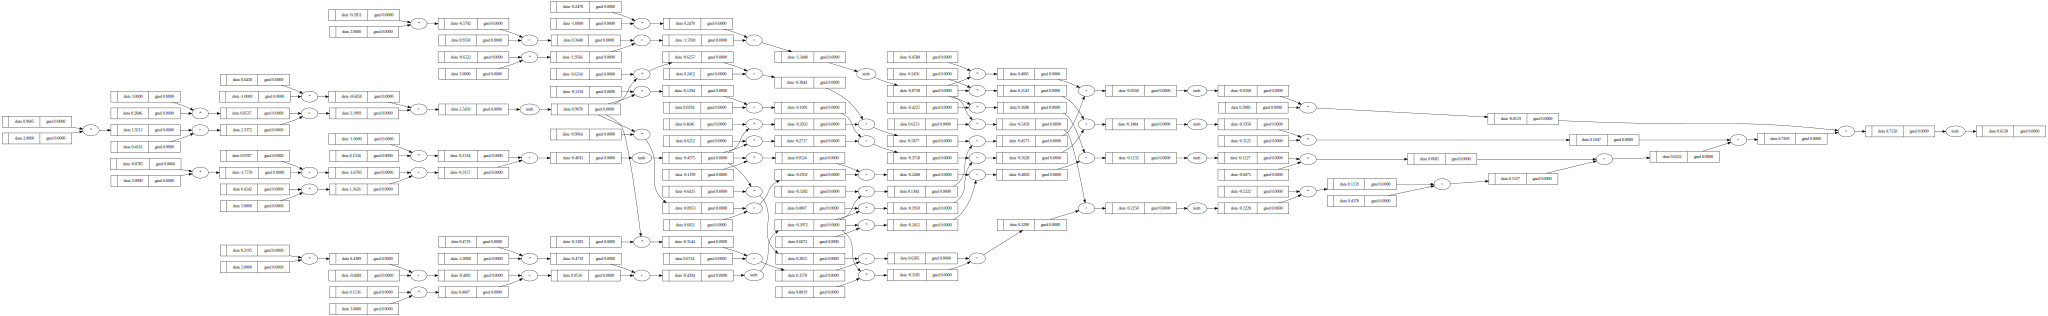

In [49]:
draw_dot(n(x))

In [50]:
# lets say we have 3d list of inputs
# and a list of targets

xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [109]:
# to get these predictions
# do the tuning to get better performance

for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  # calcualting loss for all true and pred values of y
  # loss says how well the nn is performing
  # we use mean square error loss
  
  loss = sum(((yout + (-ygt))**2 for ygt, yout in zip(ys, ypred)), start=Value(0))
  
  # backward pass
  for p in n.parameters():
    # gradient for the parameter starts at 0.0
    # for each iteration so that += in backward works well 
    # all off te parameters start to 0 at each iteration
    p.grad = 0.0
  loss.backward()
  
  # update
  # for every p parameter we change the data of taht parameter by p= p+ alpha* p.grad
  # we use - apha as we want to decrease the loss so -ve p= p- alpha*p.grad
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

0 0.0006589065032925561
1 0.0006570285753096724
2 0.0006551609972402387
3 0.0006533036848020193
4 0.0006514565546192544
5 0.0006496195242104966
6 0.0006477925119767338
7 0.0006459754371896813
8 0.000644168219980203
9 0.0006423707813270062
10 0.0006405830430454443
11 0.0006388049277765465
12 0.0006370363589761742
13 0.0006352772609043679
14 0.0006335275586148727
15 0.0006317871779447947
16 0.0006300560455044732
17 0.0006283340886674072
18 0.0006266212355604831
19 0.0006249174150542156


In [ ]:
# keep running the above and this code to see how y_pred converge to 1
# this is how stochastic gradient descent is 

[Value(data=0.9906331667074535),
 Value(data=-0.9913360540824449),
 Value(data=-0.9845899487074453),
 Value(data=0.985011797658746)]